# <center> Майнор "Интеллектуальный анализ данных" </center>

# <center> Курс "Современные методы машинного обучения" </center>

# <center> Лабораторная работа №2. Object Detection. </center>

In [ ]:
!unzip "data.zip"

In [ ]:
!pip install albumentations==0.4.6

In [ ]:
!pip install xmltodict

## Data

In [ ]:
import pandas as pd
import numpy as np
import torch
import glob
import cv2
import os
import torchvision
import matplotlib.pyplot as plt
import xmltodict, json
import albumentations as A
import time

from sklearn.metrics import auc
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch.transforms import ToTensor
from albumentations.pytorch.transforms import ToTensorV2

In [ ]:
import warnings
warnings.filterwarnings('ignore')

В этом задании потребуется обучить детектор фруктов на изображении. Данные находятся в архиве `data.zip`. Данные уже поделены на train и test.

Датасет для трех классов.

In [ ]:
class2tag = {"apple": 1, "orange": 1, "banana": 1}

In [ ]:
class FruitDataset(Dataset):
    def __init__(self, data_dir, width, height, transform=None):
        self.images = []
        self.annotations = []
        self.transform = transform
        self.height = height
        self.width = width
        for annotation in glob.glob(data_dir + "/*xml"):
            image_fname = os.path.splitext(annotation)[0] + ".jpg"
            image_before_resize = cv2.cvtColor(cv2.imread(image_fname), cv2.COLOR_BGR2RGB)
            image = cv2.resize(image_before_resize, (width, height), cv2.INTER_AREA)
            # image /= 255.0
            self.images.append(image)
            with open(annotation) as f:
                annotation_dict = xmltodict.parse(f.read())
            bboxes = []
            labels = []
            objects = annotation_dict["annotation"]["object"]
            if not isinstance(objects, list):
                objects = [objects]
            for obj in objects:
                bndbox = obj["bndbox"]
                bbox = [bndbox["xmin"], bndbox["ymin"], bndbox["xmax"], bndbox["ymax"]]
                bbox = list(map(int, bbox))
                bbox = [bbox[0]*width/image_before_resize.shape[1],
                        bbox[1]*height/image_before_resize.shape[0],
                        bbox[2]*width/image_before_resize.shape[1],
                        bbox[3]*height/image_before_resize.shape[0]]
                bbox = list(map(int, bbox))
                bboxes.append(torch.tensor(bbox))
                labels.append(class2tag[obj["name"]])
            self.annotations.append(
                {"boxes": torch.stack(bboxes).float(), "labels": torch.tensor(labels)}
            )

    def __getitem__(self, i):
        if self.transform:
            # the following code is correct if you use albumentations
            # if you use torchvision transforms you have to modify it =)
            res = self.transform(
                image=self.images[i],
                bboxes=self.annotations[i]["boxes"],
                labels=self.annotations[i]["labels"],
            )
            return res["image"], {
                "boxes": torch.tensor(res["bboxes"]),
                "labels": torch.tensor(res["labels"]),
            }
        else:
            return self.images[i], self.annotations[i]

    def __len__(self):
        return len(self.images)

In [ ]:
transform = A.Compose([
    ToTensor()])

In [ ]:
train_dataset = FruitDataset('data/train_zip/train/', 256, 256, transform)
test_dataset = FruitDataset('data/test_zip/test/', 256, 256, transform)

In [ ]:
print('length of dataset = ', len(train_dataset), '\n')
print('length of test dataset = ', len(test_dataset), '\n')

img, target = train_dataset[78]
print(img.shape, '\n',target)

length of dataset =  240 

length of test dataset =  60 

torch.Size([3, 256, 256]) 
 {'boxes': tensor([[ 21.,  72., 173., 237.]]), 'labels': tensor([1])}


<br>  
<br>  
Функции для вычисления mAP.

In [ ]:
def intersection_over_union(dt_bbox, gt_bbox):
    """
    Intersection over Union between two bboxes
    :param dt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :param gt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :return : intersection over union
    """

    ## TODO YOUR CODE

    intersection_bbox = np.array(
        [
            max(dt_bbox[0], gt_bbox[0]),
            max(dt_bbox[1], gt_bbox[1]),
            min(dt_bbox[2], gt_bbox[2]),
            min(dt_bbox[3], gt_bbox[3]),
        ]
    )

    intersection_area = max(intersection_bbox[2] - intersection_bbox[0], 0) * max(
        intersection_bbox[3] - intersection_bbox[1], 0
    )
    area_dt = (dt_bbox[2] - dt_bbox[0]) * (dt_bbox[3] - dt_bbox[1])
    area_gt = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])

    union_area = area_dt + area_gt - intersection_area

    iou = intersection_area / union_area
    return iou

def evaluate_sample(target_pred, target_true, iou_threshold=0.5):
    gt_bboxes = target_true["boxes"].numpy()
    gt_labels = target_true["labels"].numpy()

    dt_bboxes = target_pred["boxes"].numpy()
    dt_labels = target_pred["labels"].numpy()
    dt_scores = target_pred["scores"].numpy()

    results = []
    for detection_id in range(len(dt_labels)):
        dt_bbox = dt_bboxes[detection_id, :]
        dt_label = dt_labels[detection_id]
        dt_score = dt_scores[detection_id]

        detection_result_dict = {"score": dt_score}

        max_IoU = 0
        max_gt_id = -1
        for gt_id in range(len(gt_labels)):
            gt_bbox = gt_bboxes[gt_id, :]
            gt_label = gt_labels[gt_id]

            if gt_label != dt_label:
                continue

            if intersection_over_union(dt_bbox, gt_bbox) > max_IoU:
                max_IoU = intersection_over_union(dt_bbox, gt_bbox)
                max_gt_id = gt_id

        if max_gt_id >= 0 and max_IoU >= iou_threshold:
            detection_result_dict["TP"] = 1
            gt_labels = np.delete(gt_labels, max_gt_id, axis=0)
            gt_bboxes = np.delete(gt_bboxes, max_gt_id, axis=0)

        else:
            detection_result_dict["TP"] = 0

        results.append(detection_result_dict)

    return results


def evaluate(model, test_loader, device):
    results = []
    model.eval()
    nbr_boxes = 0
    with torch.no_grad():
        for batch, (images, targets_true) in enumerate(test_loader):
            images = list(image.to(device).float() for image in images)
            targets_pred = model(images)
            targets_true = [
                {k: v.cpu().float() for k, v in t.items()} for t in targets_true
            ]
            targets_pred = [
                {k: v.cpu().float() for k, v in t.items()} for t in targets_pred
            ]

            for i in range(len(targets_true)):
                target_true = targets_true[i]
                target_pred = targets_pred[i]
                nbr_boxes += target_true["labels"].shape[0]

                results.extend(evaluate_sample(target_pred, target_true))

    results = sorted(results, key=lambda k: k["score"], reverse=True)
    # results[:] = [d for d in results if d.get("score") > 0.75]
    # print(results)

    acc_TP = np.zeros(len(results))
    acc_FP = np.zeros(len(results))
    recall = np.zeros(len(results))
    precision = np.zeros(len(results))

    if results[0]["TP"] == 1:
        acc_TP[0] = 1
    else:
        acc_FP[0] = 1

    for i in range(1, len(results)):
        acc_TP[i] = results[i]["TP"] + acc_TP[i - 1]
        acc_FP[i] = (1 - results[i]["TP"]) + acc_FP[i - 1]

        precision[i] = acc_TP[i] / (acc_TP[i] + acc_FP[i])
        recall[i] = acc_TP[i] / nbr_boxes

    return auc(recall, precision)

In [ ]:
def train_one_epoch(model, optimizer, data_loader, device):
    model.train()
    n = 0
    global_loss = 0
    for images, targets in data_loader:
        images = list(image.to(device).float() for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        dict_loss = model(images, targets)
        losses = sum(loss for loss in dict_loss.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        n += 1
        global_loss += float(losses.cpu().detach().numpy())

        if n % 10 == 0:
            print("Loss value after {} batches is {}".format(n, round(global_loss / n, 2)))

    return global_loss


def train(model, num_epochs, train_loader, test_loader, optimizer, device):
    for epoch in range(num_epochs):
        print("epoch {}/{}..".format(epoch, num_epochs))
        start = time.time()
        train_one_epoch(model, optimizer, train_loader, device)
        mAP = evaluate(model, test_loader, device=device)
        end = time.time()

        print("epoch {} done in {}s".format(epoch, round(end - start, 2)))
        print("mAP after epoch {} is {}:".format(epoch, round(mAP, 3)))

def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

<br>  
<br>  
  
## Часть 1.  
  
*Вес в общей оценке - 0.4*  
  
В данной части вам нужно решить задачу детектирования фруктов "без классификации". Для этого все три класса нужно объединить в один (нужно внести соотвествующие изменения в датасет).

### Задание 1.  
  
Примените обученные детекторы из [torchvision.models](https://pytorch.org/vision/stable/models.html#object-detection-instance-segmentation-and-person-keypoint-detection) - Faster R-CNN, RetinaNet, SSD (можно только с одним backbone, можно все попробовать) - и оцените качество детекции на тестовом датасете. 

Я тестировала Faster R-CNN и RetinaNet.

In [ ]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection import retinanet_resnet50_fpn

In [ ]:
def get_detection_model(num_classes=2, pretrained=True):
    model = fasterrcnn_resnet50_fpn(pretrained=pretrained)

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [ ]:
def get_retinanet_model(pretrained=True):
    model = retinanet_resnet50_fpn(pretrained=True)
    
    return model

In [ ]:
dltrain = torch.utils.data.DataLoader(
    train_dataset, batch_size=4, shuffle=True, num_workers=4,
    collate_fn=collate_fn)

dltest = torch.utils.data.DataLoader(
    test_dataset, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=collate_fn)

In [ ]:
resnet_pretrained_model = get_detection_model()
resnet_pretrained_model.to(device)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
resnet_pretrained_model.eval()
mAP_resnet_pretrained_model = evaluate(resnet_pretrained_model, dltest, device=device)
mAP_resnet_pretrained_model

0.01691598018970559

In [ ]:
retinanet_pretrained_model = get_retinanet_model()
retinanet_pretrained_model.to(device)

Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_coco-eeacb38b.pth" to /root/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_coco-eeacb38b.pth


  0%|          | 0.00/130M [00:00<?, ?B/s]

RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, eps=0.0)


In [ ]:
retinanet_pretrained_model.eval()
mAP_retinanet_pretrained_model = evaluate(retinanet_pretrained_model, dltest, device=device)
mAP_retinanet_pretrained_model

0.0007089053827929839

Показатели очень плохие, поэтому нужно обязательно обучать модели.

### Задание 2.  
  
Обучите детекторы из задания выше на обучающем датасете, оцените качество на тестовом. При необходимости, подберите гиперпараметры - optimizer, lr, weight_decay etc.  
Выполните обучение в двух вариантах: со случайной инициализацией весов и с загрузкой весов уже обученной модели. Сравните качество. 

In [ ]:
num_epochs = 5
num_classes = 2

model = get_detection_model(num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.004, momentum=0.9, weight_decay=0.0005)
    
train(model, num_epochs, dltrain, dltest, optimizer, device)

epoch 0/5..
Loss value after 10 batches is 0.57
Loss value after 20 batches is 0.44
Loss value after 30 batches is 0.37
Loss value after 40 batches is 0.34
Loss value after 50 batches is 0.31
Loss value after 60 batches is 0.29
epoch 0 done in 137.37s
mAP after epoch 0 is 0.835:
epoch 1/5..
Loss value after 10 batches is 0.17
Loss value after 20 batches is 0.15
Loss value after 30 batches is 0.16
Loss value after 40 batches is 0.16
Loss value after 50 batches is 0.16
Loss value after 60 batches is 0.16
epoch 1 done in 137.78s
mAP after epoch 1 is 0.9:
epoch 2/5..
Loss value after 10 batches is 0.18
Loss value after 20 batches is 0.15
Loss value after 30 batches is 0.13
Loss value after 40 batches is 0.13
Loss value after 50 batches is 0.13
Loss value after 60 batches is 0.13
epoch 2 done in 137.7s
mAP after epoch 2 is 0.926:
epoch 3/5..
Loss value after 10 batches is 0.13
Loss value after 20 batches is 0.13
Loss value after 30 batches is 0.12
Loss value after 40 batches is 0.11
Loss va

In [ ]:
model_ = get_detection_model(num_classes, False)
model_.to(device)

params = [p for p in model_.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.004, momentum=0.9, weight_decay=0.0005)
    
train(model_, num_epochs, dltrain, dltest, optimizer, device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch 0/5..
Loss value after 10 batches is 1.0
Loss value after 20 batches is 0.72
Loss value after 30 batches is 0.62
Loss value after 40 batches is 0.54
Loss value after 50 batches is 0.49
Loss value after 60 batches is 0.46
epoch 0 done in 138.27s
mAP after epoch 0 is 0.283:
epoch 1/5..
Loss value after 10 batches is 0.34
Loss value after 20 batches is 0.32
Loss value after 30 batches is 0.33
Loss value after 40 batches is 0.31
Loss value after 50 batches is 0.31
Loss value after 60 batches is 0.3
epoch 1 done in 138.67s
mAP after epoch 1 is 0.523:
epoch 2/5..
Loss value after 10 batches is 0.24
Loss value after 20 batches is 0.27
Loss value after 30 batches is 0.25
Loss value after 40 batches is 0.24
Loss value after 50 batches is 0.23
Loss value after 60 batches is 0.25
epoch 2 done in 137.82s
mAP after epoch 2 is 0.66:
epoch 3/5..
Loss value after 10 batches is 0.21
Loss value after 20 batches is 0.22
Loss value after 30 batches is 0.23
Loss value after 40 batches is 0.23
Loss va

In [ ]:
model_retina = get_retinanet_model()
model_retina.to(device)

params_retina = [p for p in model_retina.parameters() if p.requires_grad]
optimizer_retina = torch.optim.SGD(params_retina, lr=0.001, momentum=0.9, weight_decay=0.0005)
    
train(model_retina, num_epochs, dltrain, dltest, optimizer_retina, device)

epoch 0/5..
Loss value after 10 batches is 0.83
Loss value after 20 batches is 0.66
Loss value after 30 batches is 0.58
Loss value after 40 batches is 0.53
Loss value after 50 batches is 0.5
Loss value after 60 batches is 0.46
epoch 0 done in 176.48s
mAP after epoch 0 is 0.89:
epoch 1/5..
Loss value after 10 batches is 0.25
Loss value after 20 batches is 0.26
Loss value after 30 batches is 0.25
Loss value after 40 batches is 0.24
Loss value after 50 batches is 0.24
Loss value after 60 batches is 0.24
epoch 1 done in 176.36s
mAP after epoch 1 is 0.928:
epoch 2/5..
Loss value after 10 batches is 0.19
Loss value after 20 batches is 0.19
Loss value after 30 batches is 0.18
Loss value after 40 batches is 0.18
Loss value after 50 batches is 0.18
Loss value after 60 batches is 0.18
epoch 2 done in 176.22s
mAP after epoch 2 is 0.935:
epoch 3/5..
Loss value after 10 batches is 0.15
Loss value after 20 batches is 0.14
Loss value after 30 batches is 0.15
Loss value after 40 batches is 0.15
Loss v

In [ ]:
model_retina_ = get_retinanet_model(False)
model_retina_.to(device)

params_retina_ = [p for p in model_retina_.parameters() if p.requires_grad]
optimizer_retina_ = torch.optim.SGD(params_retina_, lr=0.001, momentum=0.9, weight_decay=0.0005)
    
train(model_retina_, num_epochs, dltrain, dltest, optimizer_retina_, device)

epoch 0/5..
Loss value after 10 batches is 0.83
Loss value after 20 batches is 0.61
Loss value after 30 batches is 0.53
Loss value after 40 batches is 0.48
Loss value after 50 batches is 0.45
Loss value after 60 batches is 0.43
epoch 0 done in 176.51s
mAP after epoch 0 is 0.9:
epoch 1/5..
Loss value after 10 batches is 0.29
Loss value after 20 batches is 0.26
Loss value after 30 batches is 0.25
Loss value after 40 batches is 0.23
Loss value after 50 batches is 0.22
Loss value after 60 batches is 0.22
epoch 1 done in 176.44s
mAP after epoch 1 is 0.915:
epoch 2/5..
Loss value after 10 batches is 0.2
Loss value after 20 batches is 0.18
Loss value after 30 batches is 0.17
Loss value after 40 batches is 0.17
Loss value after 50 batches is 0.17
Loss value after 60 batches is 0.17
epoch 2 done in 176.24s
mAP after epoch 2 is 0.946:
epoch 3/5..
Loss value after 10 batches is 0.14
Loss value after 20 batches is 0.14
Loss value after 30 batches is 0.15
Loss value after 40 batches is 0.15
Loss va

В результате экспериментов я обнаружила, что pretrained модель R-CNN работает лучше, чем не натренированная, а вот ResNet после 5 эпох обучения показал результат лучше.

Я решила, что перед тем, как определиться на модели, с которой я буду дальше работать, я посмотрю, как визуально выглядят изображения с найденными bounding boxes.

In [ ]:
from PIL import ImageDraw

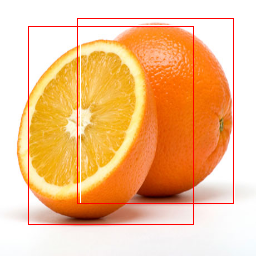

In [ ]:
image, labels = test_dataset[15]
pred = model(image.unsqueeze(0).to(device))[0]

image = torchvision.transforms.ToPILImage()(image)
draw = ImageDraw.Draw(image)
for box in labels['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])])
    
for box in pred['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='red')
image

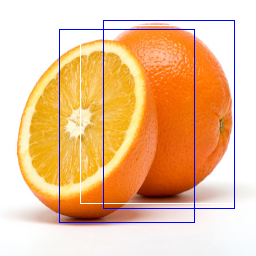

In [ ]:
image, labels = test_dataset[15]
pred = model_retina_(image.unsqueeze(0).to(device))[0]

image = torchvision.transforms.ToPILImage()(image)
draw = ImageDraw.Draw(image)
for box in labels['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])])
    
for box in pred['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='blue')
image

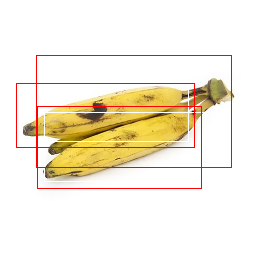

In [ ]:
image, labels = test_dataset[10]
pred = model(image.unsqueeze(0).to(device))[0]

image = torchvision.transforms.ToPILImage()(image)
draw = ImageDraw.Draw(image)
for box in labels['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])])
    
for box in pred['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='red')
image

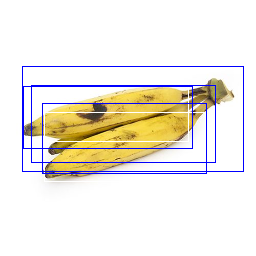

In [ ]:
image, labels = test_dataset[10]
pred = model_retina(image.unsqueeze(0).to(device))[0]

image = torchvision.transforms.ToPILImage()(image)
draw = ImageDraw.Draw(image)
for box in labels['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])])
    
for box in pred['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='blue')
image

Я решила остановиться на pretrained R-CNN.

### Задание 3.  
  
- Для лучшей модели оцените, как меняется качество на тестовых данных при изменении порога IoU.  
- Также добавьте порог для минимального значения score у предсказанных bounding box'ов, таким образом отсеивая предсказания с низким конфиденсом. Оцените, как меняется качество при изменении порога (порог IoU используйте 0.5). 

In [ ]:
def evaluate_sample(target_pred, target_true, iou_threshold=0.5):
    gt_bboxes = target_true["boxes"].numpy()
    gt_labels = target_true["labels"].numpy()

    dt_bboxes = target_pred["boxes"].numpy()
    dt_labels = target_pred["labels"].numpy()
    dt_scores = target_pred["scores"].numpy()

    results = []
    for detection_id in range(len(dt_labels)):
        dt_bbox = dt_bboxes[detection_id, :]
        dt_label = dt_labels[detection_id]
        dt_score = dt_scores[detection_id]

        detection_result_dict = {"score": dt_score}

        max_IoU = 0
        max_gt_id = -1
        for gt_id in range(len(gt_labels)):
            gt_bbox = gt_bboxes[gt_id, :]
            gt_label = gt_labels[gt_id]

            if gt_label != dt_label:
                continue

            if intersection_over_union(dt_bbox, gt_bbox) > max_IoU:
                max_IoU = intersection_over_union(dt_bbox, gt_bbox)
                max_gt_id = gt_id

        if max_gt_id >= 0 and max_IoU >= iou_threshold:
            detection_result_dict["TP"] = 1
            gt_labels = np.delete(gt_labels, max_gt_id, axis=0)
            gt_bboxes = np.delete(gt_bboxes, max_gt_id, axis=0)

        else:
            detection_result_dict["TP"] = 0

        results.append(detection_result_dict)

    return results


def evaluate(model, test_loader, device):
    results = []
    model.eval()
    nbr_boxes = 0
    with torch.no_grad():
        for batch, (images, targets_true) in enumerate(test_loader):
            images = list(image.to(device).float() for image in images)
            targets_pred = model(images)
            targets_true = [
                {k: v.cpu().float() for k, v in t.items()} for t in targets_true
            ]
            targets_pred = [
                {k: v.cpu().float() for k, v in t.items()} for t in targets_pred
            ]

            for i in range(len(targets_true)):
                target_true = targets_true[i]
                target_pred = targets_pred[i]
                nbr_boxes += target_true["labels"].shape[0]

                results.extend(evaluate_sample(target_pred, target_true))

    results = sorted(results, key=lambda k: k["score"], reverse=True)
    # results[:] = [d for d in results if d.get("score") > 0.75]
    # print(results)

    acc_TP = np.zeros(len(results))
    acc_FP = np.zeros(len(results))
    recall = np.zeros(len(results))
    precision = np.zeros(len(results))

    if results[0]["TP"] == 1:
        acc_TP[0] = 1
    else:
        acc_FP[0] = 1

    for i in range(1, len(results)):
        acc_TP[i] = results[i]["TP"] + acc_TP[i - 1]
        acc_FP[i] = (1 - results[i]["TP"]) + acc_FP[i - 1]

        precision[i] = acc_TP[i] / (acc_TP[i] + acc_FP[i])
        recall[i] = acc_TP[i] / nbr_boxes

    return auc(recall, precision)

In [ ]:
# Поменяла значение порога в функции по default на 0.1

result = evaluate(model, dltest, device=device)
result

0.9601212109591416

In [ ]:
# Поменяла значение в функции по default на 0.25

result = evaluate(model, dltest, device=device)
result

0.9545862835382541

In [ ]:
# 0.5

result = evaluate(model, dltest, device=device)
result

0.9417998085501209

In [ ]:
# 0.75

result = evaluate(model, dltest, device=device)
result

0.7227141332025095

Логично, что чем меньше нам требуется пересечение, чтобы счесть предсказание правильным, тем лучше будет метрика. Но тогда у нас будет огромное кол-во "верных" bounding boxes, которые немного пересекаются с правильным вариантом.

Пробую изменить score:



In [ ]:
# Если score больше 0.25

result = evaluate(model, dltest, device=device)
result

[{'score': 0.9992667, 'TP': 1}, {'score': 0.99910897, 'TP': 1}, {'score': 0.9990922, 'TP': 1}, {'score': 0.9990638, 'TP': 1}, {'score': 0.99893874, 'TP': 1}, {'score': 0.9988612, 'TP': 1}, {'score': 0.99881065, 'TP': 1}, {'score': 0.9987526, 'TP': 1}, {'score': 0.9987337, 'TP': 1}, {'score': 0.9987041, 'TP': 1}, {'score': 0.998606, 'TP': 1}, {'score': 0.99860543, 'TP': 1}, {'score': 0.99858826, 'TP': 1}, {'score': 0.9985215, 'TP': 1}, {'score': 0.99850464, 'TP': 1}, {'score': 0.9983851, 'TP': 1}, {'score': 0.9983004, 'TP': 1}, {'score': 0.9981698, 'TP': 1}, {'score': 0.99814653, 'TP': 1}, {'score': 0.998033, 'TP': 1}, {'score': 0.9979115, 'TP': 1}, {'score': 0.9978968, 'TP': 1}, {'score': 0.9978471, 'TP': 1}, {'score': 0.9977914, 'TP': 1}, {'score': 0.9977702, 'TP': 1}, {'score': 0.9977695, 'TP': 1}, {'score': 0.9977245, 'TP': 1}, {'score': 0.9977229, 'TP': 1}, {'score': 0.9977081, 'TP': 1}, {'score': 0.9977003, 'TP': 1}, {'score': 0.99768054, 'TP': 1}, {'score': 0.99762267, 'TP': 1}, 

0.9319502292518109

In [ ]:
# Если score больше 0.5

result = evaluate(model, dltest, device=device)
result

[{'score': 0.9992667, 'TP': 1}, {'score': 0.99910897, 'TP': 1}, {'score': 0.9990922, 'TP': 1}, {'score': 0.9990638, 'TP': 1}, {'score': 0.99893874, 'TP': 1}, {'score': 0.9988612, 'TP': 1}, {'score': 0.99881065, 'TP': 1}, {'score': 0.9987526, 'TP': 1}, {'score': 0.9987337, 'TP': 1}, {'score': 0.9987041, 'TP': 1}, {'score': 0.998606, 'TP': 1}, {'score': 0.99860543, 'TP': 1}, {'score': 0.99858826, 'TP': 1}, {'score': 0.9985215, 'TP': 1}, {'score': 0.99850464, 'TP': 1}, {'score': 0.9983851, 'TP': 1}, {'score': 0.9983004, 'TP': 1}, {'score': 0.9981698, 'TP': 1}, {'score': 0.99814653, 'TP': 1}, {'score': 0.998033, 'TP': 1}, {'score': 0.9979115, 'TP': 1}, {'score': 0.9978968, 'TP': 1}, {'score': 0.9978471, 'TP': 1}, {'score': 0.9977914, 'TP': 1}, {'score': 0.9977702, 'TP': 1}, {'score': 0.9977695, 'TP': 1}, {'score': 0.9977245, 'TP': 1}, {'score': 0.9977229, 'TP': 1}, {'score': 0.9977081, 'TP': 1}, {'score': 0.9977003, 'TP': 1}, {'score': 0.99768054, 'TP': 1}, {'score': 0.99762267, 'TP': 1}, 

0.931950229251811

In [ ]:
# Если score больше 0.75

result = evaluate(model, dltest, device=device)
result

[{'score': 0.9992667, 'TP': 1}, {'score': 0.99910897, 'TP': 1}, {'score': 0.9990922, 'TP': 1}, {'score': 0.9990638, 'TP': 1}, {'score': 0.99893874, 'TP': 1}, {'score': 0.9988612, 'TP': 1}, {'score': 0.99881065, 'TP': 1}, {'score': 0.9987526, 'TP': 1}, {'score': 0.9987337, 'TP': 1}, {'score': 0.9987041, 'TP': 1}, {'score': 0.998606, 'TP': 1}, {'score': 0.99860543, 'TP': 1}, {'score': 0.99858826, 'TP': 1}, {'score': 0.9985215, 'TP': 1}, {'score': 0.99850464, 'TP': 1}, {'score': 0.9983851, 'TP': 1}, {'score': 0.9983004, 'TP': 1}, {'score': 0.9981698, 'TP': 1}, {'score': 0.99814653, 'TP': 1}, {'score': 0.998033, 'TP': 1}, {'score': 0.9979115, 'TP': 1}, {'score': 0.9978968, 'TP': 1}, {'score': 0.9978471, 'TP': 1}, {'score': 0.9977914, 'TP': 1}, {'score': 0.9977702, 'TP': 1}, {'score': 0.9977695, 'TP': 1}, {'score': 0.9977245, 'TP': 1}, {'score': 0.9977229, 'TP': 1}, {'score': 0.9977081, 'TP': 1}, {'score': 0.9977003, 'TP': 1}, {'score': 0.99768054, 'TP': 1}, {'score': 0.99762267, 'TP': 1}, 

0.9249686278895741

### Задание 4.  
  
Нарисуйте предсказанные bounding box'ы для любых двух картинок из __тестового__ датасета и каких-нибудь картинок из __интернета__ (релевантных - где есть эти фрукты - и тех, где этих фруктов нет).

In [ ]:
transform = A.Compose([
            A.Resize(height=256, width=256),
            ToTensor()
            ])

def print_image_from_dataset(img):
    image, labels = img
    pred = model(image.unsqueeze(0).to(device))[0]

    image = torchvision.transforms.ToPILImage()(image)
    draw = ImageDraw.Draw(image)

    for box in labels['boxes']:
        draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='blue')


    for i in range(len(pred['scores'])):
        if pred['scores'][i] > 0.5:
            draw.rectangle([(pred['boxes'][i][0], pred['boxes'][i][1]), 
                          (pred['boxes'][i][2], pred['boxes'][i][3])], outline='red')

    plt.imshow(image)

def print_image_from_dir(img):

    image = transform(image=cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB))

    pred = model(image["image"].unsqueeze(0).to(device))[0]

    image = torchvision.transforms.ToPILImage()(image["image"])
    draw = ImageDraw.Draw(image)

    for i in range(len(pred['scores'])):
        if pred['scores'][i] > 0.5:
            draw.rectangle([(pred['boxes'][i][0], pred['boxes'][i][1]), 
                          (pred['boxes'][i][2], pred['boxes'][i][3])], outline='red')

    plt.imshow(image)

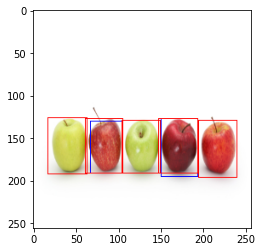

In [ ]:
print_image_from_dataset(test_dataset[7])

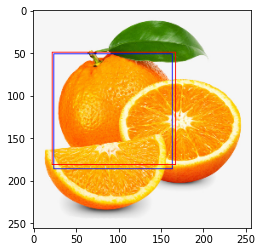

In [ ]:
print_image_from_dataset(test_dataset[17])

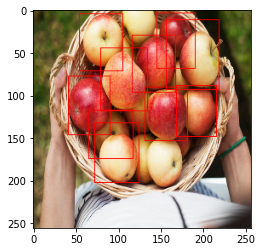

In [ ]:
print_image_from_dir('apple.jpg')

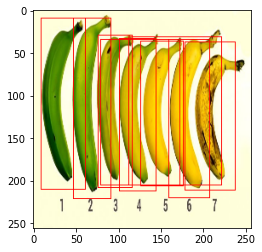

In [ ]:
print_image_from_dir('banana.jpg')

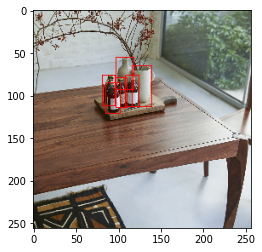

In [ ]:
print_image_from_dir('table.jpg')

Я выводила только те bounding boxes, которые имеют score больше 0.5. Как мне показалось, модель весьма неплохо определяет фрукты, но и модель может какие-то предметы спутать с фруктами.

### Задание 5.  
  
Реализуйте и примените Non-maximum Suppression. Оцените (визуально и по метрикам), как его использование влияет на качество детекции.   
**NB:** Чтобы продемонстрировать эффективность применения алгоритма, возможно, нужно будет взять достаточно низкий порог конфиденса. 

In [ ]:
def nms(pred, iou):
  
    keep = torchvision.ops.nms(pred['boxes'], pred['scores'], iou)
    
    res = pred
    res['boxes'] = res['boxes'][keep]
    res['scores'] = res['scores'][keep]
    res['labels'] = res['labels'][keep]
    
    return res

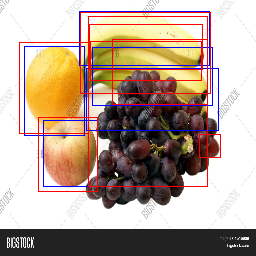

In [ ]:
image, labels = test_dataset[11]
pred = model(image.unsqueeze(0).to(device))[0]

image = torchvision.transforms.ToPILImage()(image)
draw = ImageDraw.Draw(image)

for box in labels['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='blue')


for box in pred['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='red')

image

In [ ]:
pred

{'boxes': tensor([[ 80.6920,  12.6578, 210.1005,  93.8067],
         [ 19.2423,  42.9190,  88.4442, 133.6014],
         [ 38.7960, 117.8318,  97.7459, 191.1782],
         [ 90.0518,  41.5967, 201.6429,  80.3951],
         [ 89.0376,  24.6616, 202.1281,  69.1849],
         [112.5869,  39.4158, 207.0560, 104.2203],
         [ 88.2136,  16.2960, 207.9761, 186.8939],
         [199.5536, 134.7542, 220.1143, 157.4663]], device='cuda:0',
        grad_fn=<StackBackward0>),
 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'),
 'scores': tensor([0.9945, 0.9929, 0.9768, 0.3033, 0.1053, 0.0951, 0.0844, 0.0523],
        device='cuda:0', grad_fn=<IndexBackward0>)}

In [ ]:
nms_prediction = nms(pred, 0.1)
nms_prediction

{'boxes': tensor([[ 80.6920,  12.6578, 210.1005,  93.8067],
         [ 19.2423,  42.9190,  88.4442, 133.6014],
         [ 38.7960, 117.8318,  97.7459, 191.1782],
         [199.5536, 134.7542, 220.1143, 157.4663]], device='cuda:0',
        grad_fn=<IndexBackward0>),
 'labels': tensor([1, 1, 1, 1], device='cuda:0'),
 'scores': tensor([0.9945, 0.9929, 0.9768, 0.0523], device='cuda:0',
        grad_fn=<IndexBackward0>)}

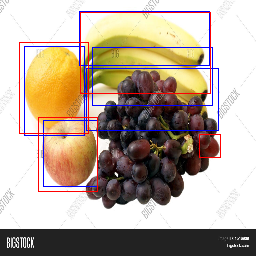

In [ ]:
image, labels = test_dataset[11]
image = torchvision.transforms.ToPILImage()(image)
draw = ImageDraw.Draw(image)

for box in labels['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='blue')


for box in nms_prediction['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='red')

image

In [ ]:
nms_prediction = nms(pred, 0.2)
nms_prediction

{'boxes': tensor([[ 80.6920,  12.6578, 210.1005,  93.8067],
         [ 19.2423,  42.9190,  88.4442, 133.6014],
         [ 38.7960, 117.8318,  97.7459, 191.1782],
         [199.5536, 134.7542, 220.1143, 157.4663]], device='cuda:0',
        grad_fn=<IndexBackward0>),
 'labels': tensor([1, 1, 1, 1], device='cuda:0'),
 'scores': tensor([0.9945, 0.9929, 0.9768, 0.0523], device='cuda:0',
        grad_fn=<IndexBackward0>)}

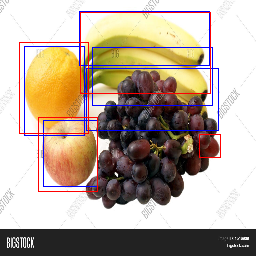

In [ ]:
image, labels = test_dataset[11]
image = torchvision.transforms.ToPILImage()(image)
draw = ImageDraw.Draw(image)

for box in labels['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='blue')


for box in nms_prediction['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='red')

image

In [ ]:
def evaluate_with_nms(model, test_loader, nms_iou, device):
    results = []
    model.eval()
    nbr_boxes = 0
    with torch.no_grad():
        for batch, (images, targets_true) in enumerate(test_loader):
            images = list(image.to(device).float() for image in images)
            targets_pred = model(images)

            for target_true, target_pred in zip(targets_true, targets_pred):
                keep = torchvision.ops.nms(target_pred['boxes'], target_pred['scores'], nms_iou)
                target_pred['boxes'] = target_pred['boxes'][keep].cpu().float()
                target_pred['scores'] = target_pred['scores'][keep].cpu().float()
                target_pred['labels'] = target_pred['labels'][keep].cpu().float()

                target_true = {k: v.cpu().float() for k, v in target_true.items()}
                nbr_boxes += target_true["labels"].shape[0]

                results.extend(evaluate_sample(target_pred, target_true))

    results = sorted(results, key=lambda k: k["score"], reverse=True)
    # results[:] = [d for d in results if d.get("score") > 0.75]
    # print(results)

    acc_TP = np.zeros(len(results))
    acc_FP = np.zeros(len(results))
    recall = np.zeros(len(results))
    precision = np.zeros(len(results))

    if results[0]["TP"] == 1:
        acc_TP[0] = 1
    else:
        acc_FP[0] = 1

    for i in range(1, len(results)):
        acc_TP[i] = results[i]["TP"] + acc_TP[i - 1]
        acc_FP[i] = (1 - results[i]["TP"]) + acc_FP[i - 1]

        precision[i] = acc_TP[i] / (acc_TP[i] + acc_FP[i])
        recall[i] = acc_TP[i] / nbr_boxes

    return auc(recall, precision)


In [ ]:
result = evaluate(model, dltest, device)
result

0.9417998085501209

In [ ]:
result = evaluate_with_nms(model, dltest, 1.0, device)
result

0.9417998085501209

In [ ]:
result = evaluate_with_nms(model, dltest, 0.8, device)
result

0.9417998085501209

In [ ]:
result = evaluate_with_nms(model, dltest, 0.5, device)
result

0.9417998085501209

In [ ]:
result = evaluate_with_nms(model, dltest, 0.45, device)
result

0.9211144712170083

In [ ]:
result = evaluate_with_nms(model, dltest, 0.4, device)
result

0.9044661570294215

In [ ]:
result = evaluate_with_nms(model, dltest, 0.3, device)
result

0.8657668613389873

NMS мне кажется не подходящим для данного датасета, так как на многих фотографиях один предмет находится за другим, соотвественно, bounding boxes сильно пересекаются, а NMS может один из bounding boxes убрать, от этого точность уменьшается. Но визуально выглядит лучше.

<br>  
<br>  
  
## Часть 2.  
  
*Вес в общей оценке - 0.4*  
  
Выполните задания 2-5 из предыдущей части для случая 3-х классов (как в изначальном датасете).

In [ ]:
class2tag = {"apple": 1, "orange": 2, "banana": 3}

In [ ]:
train_dataset3 = FruitDataset('data/train_zip/train/', 256, 256, transform)
test_dataset3 = FruitDataset('data/test_zip/test/', 256, 256, transform)

In [ ]:
print('length of dataset = ', len(train_dataset3), '\n')
print('length of test dataset = ', len(test_dataset3), '\n')

img, target = train_dataset3[79]
print(img.shape, '\n',target)

length of dataset =  240 

length of test dataset =  60 

torch.Size([3, 256, 256]) 
 {'boxes': tensor([[ 31.,  41., 161., 256.],
        [ 70.,  35., 222., 163.],
        [ 64.,  32., 214., 222.],
        [ 77.,  37., 218., 186.]]), 'labels': tensor([3, 3, 3, 3])}


In [ ]:
dltrain3 = torch.utils.data.DataLoader(
    train_dataset3, batch_size=4, shuffle=True, num_workers=4,
    collate_fn=collate_fn)

dltest3 = torch.utils.data.DataLoader(
    test_dataset3, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=collate_fn)

In [ ]:
resnet_pretrained_model = get_detection_model(4)
resnet_pretrained_model.to(device)

In [ ]:
resnet_pretrained_model.eval()
mAP_resnet_pretrained_model = evaluate(resnet_pretrained_model, dltest3, device=device)
mAP_resnet_pretrained_model

0.00020734306227101877

In [ ]:
retinanet_pretrained_model = get_retinanet_model()
retinanet_pretrained_model.to(device)

In [ ]:
retinanet_pretrained_model.eval()
mAP_retinanet_pretrained_model = evaluate(retinanet_pretrained_model, dltest, device=device)
mAP_retinanet_pretrained_model

0.0007089053827929839

In [ ]:
num_classes = 4

model3 = get_detection_model(num_classes)
model3.to(device)

params3 = [p for p in model3.parameters() if p.requires_grad]
optimizer3 = torch.optim.SGD(params3, lr=0.005, momentum=0.9, weight_decay=0.0005)
    
train(model3, num_epochs, dltrain3, dltest3, optimizer3, device)

epoch 0/5..
Loss value after 10 batches is 0.79
Loss value after 20 batches is 0.57
Loss value after 30 batches is 0.5
Loss value after 40 batches is 0.46
Loss value after 50 batches is 0.42
Loss value after 60 batches is 0.38
epoch 0 done in 138.72s
mAP after epoch 0 is 0.849:
epoch 1/5..
Loss value after 10 batches is 0.21
Loss value after 20 batches is 0.2
Loss value after 30 batches is 0.19
Loss value after 40 batches is 0.19
Loss value after 50 batches is 0.19
Loss value after 60 batches is 0.2
epoch 1 done in 138.31s
mAP after epoch 1 is 0.842:
epoch 2/5..
Loss value after 10 batches is 0.16
Loss value after 20 batches is 0.16
Loss value after 30 batches is 0.16
Loss value after 40 batches is 0.15
Loss value after 50 batches is 0.16
Loss value after 60 batches is 0.16
epoch 2 done in 137.95s
mAP after epoch 2 is 0.917:
epoch 3/5..
Loss value after 10 batches is 0.1
Loss value after 20 batches is 0.13
Loss value after 30 batches is 0.13
Loss value after 40 batches is 0.13
Loss val

In [ ]:
num_classes = 4

model3 = get_detection_model(num_classes)
model3.to(device)

params3 = [p for p in model3.parameters() if p.requires_grad]
optimizer3 = torch.optim.SGD(params3, lr=0.004, momentum=0.9, weight_decay=0.0005)
    
train(model3, num_epochs, dltrain3, dltest3, optimizer3, device)

epoch 0/5..
Loss value after 10 batches is 0.65
Loss value after 20 batches is 0.55
Loss value after 30 batches is 0.49
Loss value after 40 batches is 0.46
Loss value after 50 batches is 0.42
Loss value after 60 batches is 0.38
epoch 0 done in 138.8s
mAP after epoch 0 is 0.812:
epoch 1/5..
Loss value after 10 batches is 0.23
Loss value after 20 batches is 0.22
Loss value after 30 batches is 0.22
Loss value after 40 batches is 0.21
Loss value after 50 batches is 0.2
Loss value after 60 batches is 0.2
epoch 1 done in 138.39s
mAP after epoch 1 is 0.899:
epoch 2/5..
Loss value after 10 batches is 0.16
Loss value after 20 batches is 0.16
Loss value after 30 batches is 0.17
Loss value after 40 batches is 0.17
Loss value after 50 batches is 0.16
Loss value after 60 batches is 0.17
epoch 2 done in 138.19s
mAP after epoch 2 is 0.895:
epoch 3/5..
Loss value after 10 batches is 0.13
Loss value after 20 batches is 0.12
Loss value after 30 batches is 0.13
Loss value after 40 batches is 0.13
Loss va

In [ ]:
model3_ = get_detection_model(num_classes, False)
model3_.to(device)

params3_ = [p for p in model3_.parameters() if p.requires_grad]
optimizer3_ = torch.optim.SGD(params3_, lr=0.005, momentum=0.9, weight_decay=0.0005)
    
train(model3_, num_epochs, dltrain3, dltest3, optimizer3_, device)

epoch 0/5..
Loss value after 10 batches is 1.08
Loss value after 20 batches is 0.71
Loss value after 30 batches is 0.63
Loss value after 40 batches is 0.58
Loss value after 50 batches is 0.57
Loss value after 60 batches is 0.54
epoch 0 done in 144.08s
mAP after epoch 0 is 0.047:
epoch 1/5..
Loss value after 10 batches is 0.43
Loss value after 20 batches is 0.38
Loss value after 30 batches is 0.38
Loss value after 40 batches is 0.38
Loss value after 50 batches is 0.37
Loss value after 60 batches is 0.38
epoch 1 done in 144.32s
mAP after epoch 1 is 0.16:
epoch 2/5..
Loss value after 10 batches is 0.41
Loss value after 20 batches is 0.35
Loss value after 30 batches is 0.33
Loss value after 40 batches is 0.33
Loss value after 50 batches is 0.32
Loss value after 60 batches is 0.32
epoch 2 done in 145.26s
mAP after epoch 2 is 0.349:
epoch 3/5..
Loss value after 10 batches is 0.3
Loss value after 20 batches is 0.32
Loss value after 30 batches is 0.31
Loss value after 40 batches is 0.29
Loss v

In [ ]:
model_retina3 = get_retinanet_model()
model_retina3.to(device)

params_retina3 = [p for p in model_retina3.parameters() if p.requires_grad]
optimizer_retina3 = torch.optim.SGD(params_retina3, lr=0.001, momentum=0.9, weight_decay=0.0005)
    
train(model_retina3, num_epochs, dltrain3, dltest3, optimizer_retina3, device)

epoch 0/5..
Loss value after 10 batches is 1.18
Loss value after 20 batches is 0.86
Loss value after 30 batches is 0.73
Loss value after 40 batches is 0.63
Loss value after 50 batches is 0.58
Loss value after 60 batches is 0.54
epoch 0 done in 177.56s
mAP after epoch 0 is 0.884:
epoch 1/5..
Loss value after 10 batches is 0.32
Loss value after 20 batches is 0.28
Loss value after 30 batches is 0.27
Loss value after 40 batches is 0.25
Loss value after 50 batches is 0.26
Loss value after 60 batches is 0.26
epoch 1 done in 177.9s
mAP after epoch 1 is 0.916:
epoch 2/5..
Loss value after 10 batches is 0.2
Loss value after 20 batches is 0.2
Loss value after 30 batches is 0.2
Loss value after 40 batches is 0.2
Loss value after 50 batches is 0.19
Loss value after 60 batches is 0.19
epoch 2 done in 177.83s
mAP after epoch 2 is 0.918:
epoch 3/5..
Loss value after 10 batches is 0.15
Loss value after 20 batches is 0.16
Loss value after 30 batches is 0.16
Loss value after 40 batches is 0.16
Loss valu

In [ ]:
model_retina3_ = get_retinanet_model(False)
model_retina3_.to(device)

params_retina3_ = [p for p in model_retina3_.parameters() if p.requires_grad]
optimizer_retina3_ = torch.optim.SGD(params_retina3_, lr=0.001, momentum=0.9, weight_decay=0.0005)
    
train(model_retina3_, num_epochs, dltrain3, dltest3, optimizer_retina3_, device)

epoch 0/5..
Loss value after 10 batches is 1.25
Loss value after 20 batches is 0.95
Loss value after 30 batches is 0.79
Loss value after 40 batches is 0.7
Loss value after 50 batches is 0.63
Loss value after 60 batches is 0.57
epoch 0 done in 177.76s
mAP after epoch 0 is 0.875:
epoch 1/5..
Loss value after 10 batches is 0.24
Loss value after 20 batches is 0.26
Loss value after 30 batches is 0.26
Loss value after 40 batches is 0.26
Loss value after 50 batches is 0.25
Loss value after 60 batches is 0.25
epoch 1 done in 177.77s
mAP after epoch 1 is 0.869:
epoch 2/5..
Loss value after 10 batches is 0.21
Loss value after 20 batches is 0.22
Loss value after 30 batches is 0.21
Loss value after 40 batches is 0.21
Loss value after 50 batches is 0.21
Loss value after 60 batches is 0.2
epoch 2 done in 177.7s
mAP after epoch 2 is 0.913:
epoch 3/5..
Loss value after 10 batches is 0.18
Loss value after 20 batches is 0.16
Loss value after 30 batches is 0.16
Loss value after 40 batches is 0.16
Loss va

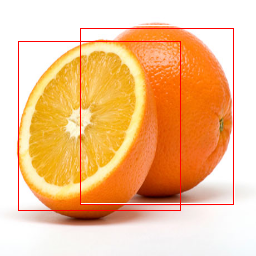

In [ ]:
image, labels = test_dataset[15]
pred = model3(image.unsqueeze(0).to(device))[0]

image = torchvision.transforms.ToPILImage()(image)
draw = ImageDraw.Draw(image)
for box in labels['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])])
    
for box in pred['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='red')
image

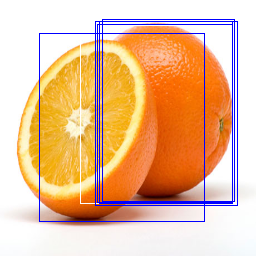

In [ ]:
image, labels = test_dataset[15]
pred = model_retina3(image.unsqueeze(0).to(device))[0]

image = torchvision.transforms.ToPILImage()(image)
draw = ImageDraw.Draw(image)
for box in labels['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])])
    
for box in pred['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='blue')
image

После экспериментов выше я снова остановилась на Faster R-CNN.

In [ ]:
# 0.25 iou threshold

result = evaluate(model3, dltest3, device=device)
result

0.9335949312880686

In [ ]:
# 0.5

result = evaluate(model3, dltest3, device=device)
result

0.9306360600121462

In [ ]:
# 0.75

result = evaluate(model3, dltest3, device=device)
result

0.6157266414702699

In [ ]:
# 0.5 score

result = evaluate(model3, dltest3, device=device)
result

[{'score': 0.9968183, 'TP': 1}, {'score': 0.9954406, 'TP': 1}, {'score': 0.99464095, 'TP': 0}, {'score': 0.99445975, 'TP': 1}, {'score': 0.9940461, 'TP': 1}, {'score': 0.9934335, 'TP': 1}, {'score': 0.9929269, 'TP': 1}, {'score': 0.9924931, 'TP': 1}, {'score': 0.99232435, 'TP': 1}, {'score': 0.99184954, 'TP': 1}, {'score': 0.99177116, 'TP': 1}, {'score': 0.9913941, 'TP': 1}, {'score': 0.9910142, 'TP': 1}, {'score': 0.99090683, 'TP': 1}, {'score': 0.9906398, 'TP': 1}, {'score': 0.990155, 'TP': 1}, {'score': 0.98954165, 'TP': 1}, {'score': 0.98938644, 'TP': 1}, {'score': 0.9892068, 'TP': 1}, {'score': 0.98904747, 'TP': 1}, {'score': 0.98889065, 'TP': 1}, {'score': 0.98883224, 'TP': 1}, {'score': 0.9887995, 'TP': 1}, {'score': 0.9886274, 'TP': 1}, {'score': 0.9881265, 'TP': 1}, {'score': 0.9874522, 'TP': 1}, {'score': 0.9874342, 'TP': 1}, {'score': 0.9872614, 'TP': 1}, {'score': 0.9871219, 'TP': 1}, {'score': 0.9870726, 'TP': 1}, {'score': 0.98684686, 'TP': 1}, {'score': 0.98636276, 'TP':

0.8943735090966776

In [ ]:
# 0.75 score

result = evaluate(model3, dltest3, device=device)
result

[{'score': 0.9968183, 'TP': 1}, {'score': 0.9954406, 'TP': 1}, {'score': 0.99464095, 'TP': 0}, {'score': 0.99445975, 'TP': 1}, {'score': 0.9940461, 'TP': 1}, {'score': 0.9934335, 'TP': 1}, {'score': 0.9929269, 'TP': 1}, {'score': 0.9924931, 'TP': 1}, {'score': 0.99232435, 'TP': 1}, {'score': 0.99184954, 'TP': 1}, {'score': 0.99177116, 'TP': 1}, {'score': 0.9913941, 'TP': 1}, {'score': 0.9910142, 'TP': 1}, {'score': 0.99090683, 'TP': 1}, {'score': 0.9906398, 'TP': 1}, {'score': 0.990155, 'TP': 1}, {'score': 0.98954165, 'TP': 1}, {'score': 0.98938644, 'TP': 1}, {'score': 0.9892068, 'TP': 1}, {'score': 0.98904747, 'TP': 1}, {'score': 0.98889065, 'TP': 1}, {'score': 0.98883224, 'TP': 1}, {'score': 0.9887995, 'TP': 1}, {'score': 0.9886274, 'TP': 1}, {'score': 0.9881265, 'TP': 1}, {'score': 0.9874522, 'TP': 1}, {'score': 0.9874342, 'TP': 1}, {'score': 0.9872614, 'TP': 1}, {'score': 0.9871219, 'TP': 1}, {'score': 0.9870726, 'TP': 1}, {'score': 0.98684686, 'TP': 1}, {'score': 0.98636276, 'TP':

0.873213296110315

In [ ]:
# 0.9 score

result = evaluate(model3, dltest3, device=device)
result

[{'score': 0.9968183, 'TP': 1}, {'score': 0.9954406, 'TP': 1}, {'score': 0.99464095, 'TP': 0}, {'score': 0.99445975, 'TP': 1}, {'score': 0.9940461, 'TP': 1}, {'score': 0.9934335, 'TP': 1}, {'score': 0.9929269, 'TP': 1}, {'score': 0.9924931, 'TP': 1}, {'score': 0.99232435, 'TP': 1}, {'score': 0.99184954, 'TP': 1}, {'score': 0.99177116, 'TP': 1}, {'score': 0.9913941, 'TP': 1}, {'score': 0.9910142, 'TP': 1}, {'score': 0.99090683, 'TP': 1}, {'score': 0.9906398, 'TP': 1}, {'score': 0.990155, 'TP': 1}, {'score': 0.98954165, 'TP': 1}, {'score': 0.98938644, 'TP': 1}, {'score': 0.9892068, 'TP': 1}, {'score': 0.98904747, 'TP': 1}, {'score': 0.98889065, 'TP': 1}, {'score': 0.98883224, 'TP': 1}, {'score': 0.9887995, 'TP': 1}, {'score': 0.9886274, 'TP': 1}, {'score': 0.9881265, 'TP': 1}, {'score': 0.9874522, 'TP': 1}, {'score': 0.9874342, 'TP': 1}, {'score': 0.9872614, 'TP': 1}, {'score': 0.9871219, 'TP': 1}, {'score': 0.9870726, 'TP': 1}, {'score': 0.98684686, 'TP': 1}, {'score': 0.98636276, 'TP':

0.8271345856595907

In [ ]:
transform = A.Compose([
        A.Resize(height=256, width=256),
        ToTensor()
    ])

def print_image_from_dataset_(img):
    image, labels = img
    pred = model3(image.unsqueeze(0).to(device))[0]

    image = torchvision.transforms.ToPILImage()(image)
    draw = ImageDraw.Draw(image)

    l = 0
    for box in labels['boxes']:
        draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='blue')
        draw.text((box[0] + 7, box[1] - 12), str(pred['labels'][l].cpu().numpy()), fill=64)
        l += 1

    for i in range(len(pred['scores'])):
        if pred['scores'][i] > 0.5:
            draw.rectangle([(pred['boxes'][i][0], pred['boxes'][i][1]), 
                          (pred['boxes'][i][2], pred['boxes'][i][3])], outline='red')
            draw.text((pred['boxes'][i][0] + 7, pred['boxes'][i][1] + 3), str(pred['labels'][i].cpu().numpy()), fill=128)

    plt.imshow(image)

def print_image_from_dir_(img):

    image = transform(image=cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB))

    pred = model3(image["image"].unsqueeze(0).to(device))[0]

    image = torchvision.transforms.ToPILImage()(image["image"])
    draw = ImageDraw.Draw(image)

    for i in range(len(pred['scores'])):
        if pred['scores'][i] > 0.5:
            draw.rectangle([(pred['boxes'][i][0], pred['boxes'][i][1]), 
                          (pred['boxes'][i][2], pred['boxes'][i][3])], outline='red')
            draw.text((pred['boxes'][i][0] + 7, pred['boxes'][i][1] + 3), str(pred['labels'][i].cpu().numpy()), fill=128)


    plt.imshow(image)

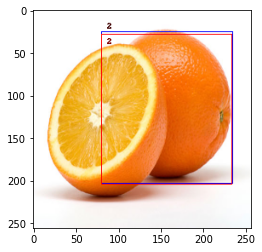

In [ ]:
print_image_from_dataset_(test_dataset[15])

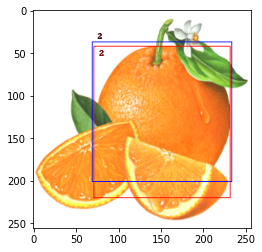

In [ ]:
print_image_from_dataset_(test_dataset[55])

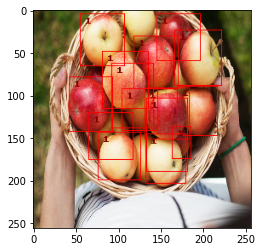

In [ ]:
print_image_from_dir_('apple.jpg')

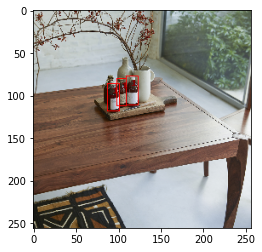

In [ ]:
print_image_from_dir_('table.jpg')

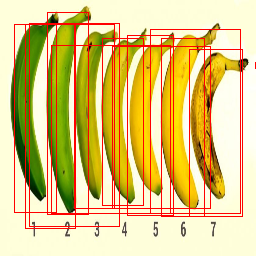

In [ ]:
image = transform(image=cv2.cvtColor(cv2.imread('banana.jpg'), cv2.COLOR_BGR2RGB))

pred = model3(image["image"].unsqueeze(0).to(device))[0]

image = torchvision.transforms.ToPILImage()(image["image"])
draw = ImageDraw.Draw(image)

for box in pred['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='red')
image

image

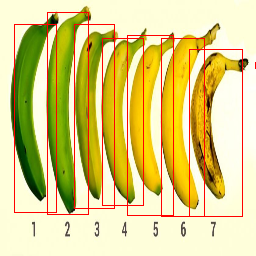

In [ ]:
nms_prediction = nms(pred, 0.3) # при 0.1 остается только 3 банана, 0.2 - 4 банана

image = transform(image=cv2.cvtColor(cv2.imread('banana.jpg'), cv2.COLOR_BGR2RGB))

image = torchvision.transforms.ToPILImage()(image["image"])

draw = ImageDraw.Draw(image)

for box in nms_prediction['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='red')
image


<br>  
<br>  
  
## Часть 3.  
  
*Вес в общей оценке - 0.2*  
  
Обучите модель для object detection для трех классов на __обучающем__ датасете и добейтесь PR AUC не менее __0.91__ на  __тестовом__.  
Баллы за задание вычисляются по формуле: __min(2, 2 * Ваш auc / 0.91)__.

Значение метрики Faster R-CNN получилось около 0.93.